In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class RBM(nn.Module):
    def __init__(self, W, v_bias, h_bias):
        super(RBM, self).__init__()
        self.W = nn.Parameter(W)
        self.v_bias = nn.Parameter(v_bias)
        self.h_bias = nn.Parameter(h_bias)

    def forward(self, v):
        v = v.float()
        h = torch.sigmoid(torch.matmul(v, self.W) + self.h_bias)
        return h

    def backward(self, h):
        #h = h.float()
        v = torch.sigmoid(torch.matmul(h, self.W.t()) + self.v_bias)
        return v
    
    def contrastive_divergence(self, v):
        v = v.squeeze(0)
        h = self.forward(v)
        v1 = self.backward(h)
        v = v.float()
        h = h.float()
        v1 = v1.float()
        
        v = v.unsqueeze(1)
        v1 = v1.unsqueeze(1)
        h = h.unsqueeze(0)
        
        positive_grad = torch.matmul(v, h)
        negative_grad = torch.matmul(v1, h)
        w_g = positive_grad - negative_grad
        
        v = v.squeeze(1)
        v1 = v1.squeeze(1)
        h = h.squeeze(0)
        
        v_b_g = torch.mean(v - v1)
        h_b_g = torch.mean(h - h)
        
        recon_error = torch.mean(v - v1)**2
        return recon_error, w_g, v_b_g, h_b_g

In [7]:
# Load your dataset
data_transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale
    transforms.Resize((78, 78)),  # Resize images to 78x78
    transforms.ToTensor()  # Convert images to tensors
])

# Modify the dataset path according to your storage configuration
dataset = datasets.ImageFolder(root='Data', transform=data_transform)
dataloader = DataLoader(dataset, batch_size=20, shuffle=True)


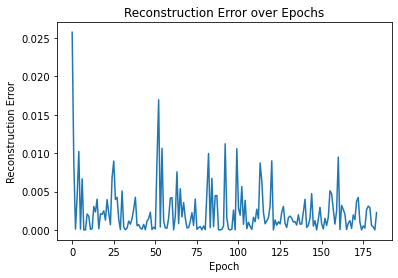

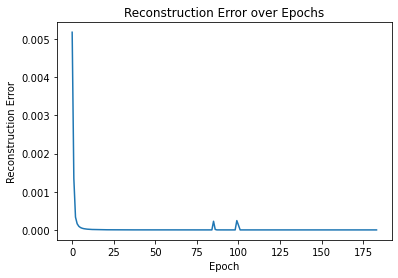

In [9]:
visible_units = 78*78*20  
hidden_units_rbm1 = 65
hidden_units_rbm2 = 65
W1 = torch.randn(visible_units, hidden_units_rbm1)*0.1
W2 = torch.randn(hidden_units_rbm1, hidden_units_rbm2)*0.1
v_bias = torch.randn(visible_units)
h1_bias = torch.randn(hidden_units_rbm1)
h2_bias = torch.randn(hidden_units_rbm2)
learning_rate = 0.1

def train_dbn(dataloader, W1, W2, v_bias, h1_bias, h2_bias, epochs=2):
    recon_error_1 = []
    for i in range(epochs):
        for batch_idx, (data, _) in enumerate(dataloader):
            b_normalized_data = data.view(-1, 78*78)
            b_normalized_data = b_normalized_data.view(-1, visible_units)
            rbm1 = RBM(W1, v_bias, h1_bias)
            recon_error, w_g, v_b_g, h_b_g = rbm1.contrastive_divergence(b_normalized_data)
            W1 += learning_rate*w_g
            v_bias += learning_rate*v_b_g
            h1_bias += learning_rate*h_b_g
            recon_error_1.append(recon_error)
    
    tensor_list = recon_error_1
    # Convert tensor list to numpy array
    numpy_array = torch.stack(tensor_list).detach().numpy()

    # Plot
    plt.plot(numpy_array.T)  # Transpose the array for proper plotting
    plt.xlabel('Epoch')
    plt.ylabel('Reconstruction Error')
    plt.title('Reconstruction Error over Epochs')
    plt.show()


    #print(recon_error_1)    
    recon_error_2 = []
    for j in range(epochs):
        for batch_idx, (data, _) in enumerate(dataloader):
            b_normalized_data = data.view(-1, visible_units)
            rbm2 = RBM(W2, h1_bias, h2_bias)
            h = torch.sigmoid(torch.matmul(b_normalized_data.float(), W1) + h1_bias)
            recon_error, w_g, v_b_g, h_b_g = rbm2.contrastive_divergence(h)
            W2 += learning_rate*w_g
            h1_bias += learning_rate*v_b_g
            h2_bias += learning_rate*h_b_g
            recon_error_2.append(recon_error)
            
    tensor_list = recon_error_2

    # Convert tensor list to numpy array
    numpy_array = torch.stack(tensor_list).detach().numpy()

    # Plot
    plt.plot(numpy_array.T)  # Transpose the array for proper plotting
    plt.xlabel('Epoch')
    plt.ylabel('Reconstruction Error')
    plt.title('Reconstruction Error over Epochs')
    plt.show()

train_dbn(dataloader, W1, W2, v_bias, h1_bias, h2_bias)

In [10]:
# Load your dataset
data_transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale
    transforms.Resize((78, 78)),  # Resize images to 78x78
    transforms.ToTensor()  # Convert images to tensors
])

# Modify the dataset path according to your storage configuration
sample_images = datasets.ImageFolder(root='Data-D-C', transform=data_transform)
sample_data = DataLoader(sample_images, batch_size=20, shuffle=True)

for batch_idx, (data, _) in enumerate(dataloader):
            sample_data = data.view(-1, 78*78)
            sample_data = sample_data.view(-1, visible_units)
            sample_data = sample_data.squeeze(0)
            break
print(sample_data.shape)

torch.Size([121680])


In [11]:
def regenerate_input(v):
    # Generate hidden activations
    h1 = torch.sigmoid(torch.matmul(v.float(), W1) + h1_bias)
    h2 = torch.sigmoid(torch.matmul(h1, W2) + h2_bias)
    h1_recon = torch.sigmoid(torch.matmul(h2, W2.t()) + h1_bias)
    v_recon = torch.sigmoid(torch.matmul(h1_recon, W1.t()) + v_bias)
    return v_recon

# Example usage:
regenerated_input = regenerate_input(sample_data)
print(regenerated_input.shape)

torch.Size([121680])


In [12]:
regenerated_input = regenerated_input.unsqueeze(0)
regenerated_input = regenerated_input.view(-1, 78*78)
regenerated_input_1 = regenerated_input[0]
                                       
regenerated_input_1.shape

torch.Size([6084])

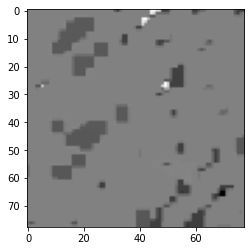

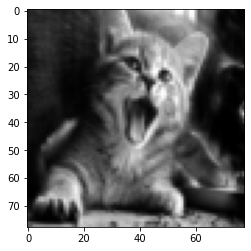

In [13]:
# Define the transformation pipeline to reverse the transformations
reverse_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL Image
])

num_channels = 1

# Apply the reverse transformation
unflattened_image = reverse_transform(regenerated_input_1.view(num_channels, 78, 78))

# Display the image
plt.imshow(unflattened_image, cmap='gray')  # Assuming the image is grayscale

plt.show()


data_transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale
    transforms.Resize((78, 78)),  # Resize images to 28x28
])
image_path = 'Data-D-C/Cat/OIP (1).jpeg'  # Modify the path according to your image file location
image = Image.open(image_path)
plt.imshow(image, cmap='gray')
sample_data = data_transform(image)
plt.imshow(sample_data, cmap='gray')


data_transform = transforms.Compose([
    transforms.ToTensor()  # Convert images to tensors
])

sample_data = data_transform(sample_data)
sample_data = sample_data.view(-1) # Flatten 

In [137]:
import torch
from skimage.metrics import structural_similarity as ssim

def calculate_metrics(original_data, regenerated_data):
    # Convert tensors to numpy arrays
    original_data_np = original_data.detach().numpy()
    regenerated_data_np = regenerated_data.detach().numpy()

    # Calculate Mean Squared Error (MSE)
    mse = ((original_data_np - regenerated_data_np) ** 2).mean()

    # Calculate Structural Similarity Index (SSIM) with appropriate window size
    min_side = min(original_data_np.shape[-2:])
    win_size = min(7, min_side)  # Ensure window size is smaller than or equal to the smaller side of the images
    # Ensure window size is odd
    win_size = win_size if win_size % 2 == 1 else win_size - 1
    ssim_value = ssim(original_data_np, regenerated_data_np, win_size=win_size, data_range=original_data_np.max() - original_data_np.min())

    return mse, ssim_value

# Example usage:
mse, ssim_value = calculate_metrics(sample_data, regenerated_input_1)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Structural Similarity Index (SSIM): {ssim_value}")


Mean Squared Error (MSE): 0.006710090208798647
Structural Similarity Index (SSIM): 0.7220421437031955
